In [1]:
import networkx as nx
import numpy as np
import osmnx as ox
import functions

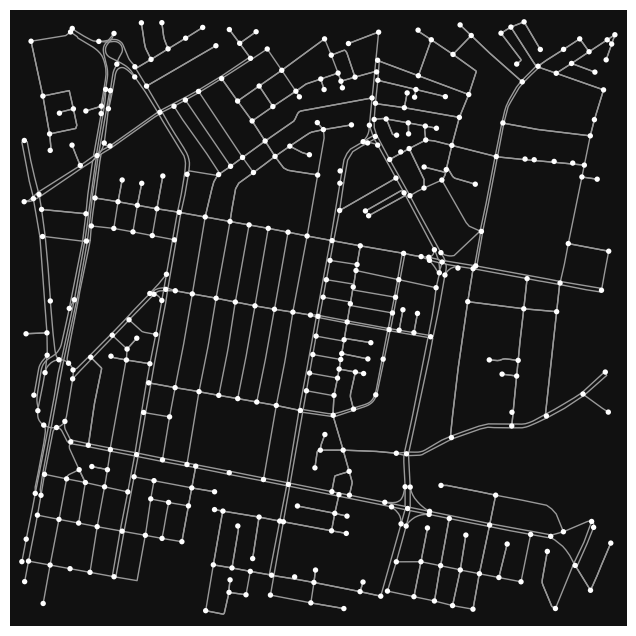

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# This location is 1 km round the location : 
G = ox.project_graph(ox.graph_from_point((-0.16509, -78.47888 ), dist=1000, network_type='drive'))
G = ox.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True)

# get data frame
df = nx.to_pandas_edgelist( G )

# Plotting the map: 
ox.plot_graph(G)

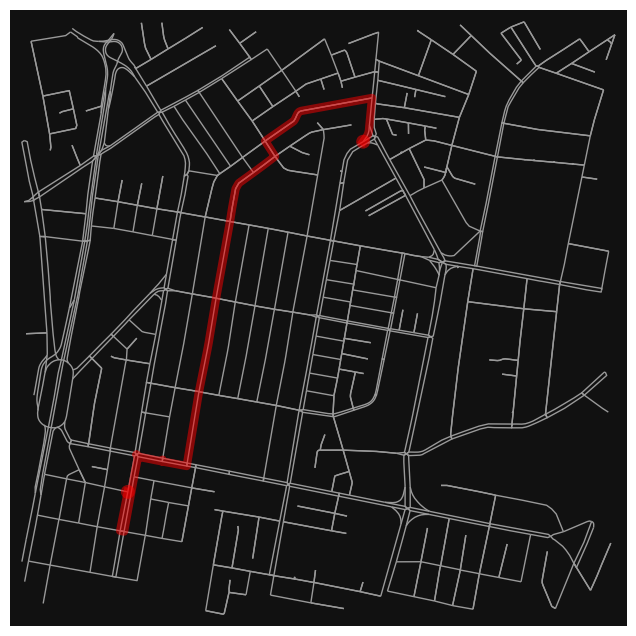

In [3]:
# plotting the shotrtest path given by netwrokX 
functions.plot_node( 52, 244 , G )

In [4]:
# def simulation function 244,52 

# get list of nodes 
list_nodes = list(G.nodes)

# get dictionary with geocordinates of each of the nodes 

coordiantes = functions.get_geo_coordinates(G)

# defining initial and final node
initial_node = list_nodes[52]
final_node = list_nodes[244]

# loop to finde the path: 

node_i = initial_node 

# to store the routes:
route= {}

path = []

# bug list
bug_list = []

# no exit list 
no_exit_list = []


while node_i != final_node:

    # store all nodes the agent pass through: 
    path.append(node_i)
    
    # measure the angle and distnac between the node_i and the destination node
    angle_i = functions.get_angle( coordiantes[ node_i ], coordiantes[ final_node] )
    dist_i = functions.get_distance( coordiantes[ node_i ], coordiantes[ final_node] ) 

    # get the neighbours of the node. The neighbours are directed nodes
    neighbors = list(G.neighbors(node_i))

    # get probality of pick a given neighbour
    factors = {}

    for node in neighbors :
        # measure angle and dist of neighbors towards final node 
        angle_neighbor = functions.get_angle( coordiantes[ node ], coordiantes[ final_node] )
        dist_neighbor = functions.get_distance( coordiantes[ node ], coordiantes[ final_node] )

        # get the length of the road

        #lenght = functions.get_length (node_i , node, G)
        
        # calculate the probability of picking a node 
        factors[node] = functions.get_factor(dist_neighbor , angle_neighbor , dist_i , angle_i , 0.6, 0.4 )

    # get probabilities
    proba_dic = functions.get_probability(factors)


    print("estoy en el nodo  ", node_i, " mis opciones son : ", proba_dic)

    # list of probable nodes_id: 
    list_proba = list(proba_dic.keys())

    # contador de veces que paso por un nodo 
    repeticions = path.count(node_i)

    for node in list_proba:
        counter = path.count(node)
        if node in path:
            proba_dic[node] = proba_dic[node]*0.4
            if counter > 2:
                 proba_dic[node] = proba_dic[node]*(0.4**counter)


    # if i have pass more than two times by a node 
    if repeticions > 2:
        
        # sotre node_i in wich bug is produced 
        bug_node = node_i
        bug_list.append(node_i)
        print("bugg en el nodo : " , bug_node )

        # count how many times a bug node has been pass through.
        counter = bug_list.count(node_i)

        if counter >= 3:
            vecinos_i = list(G.neighbors(node_i))
            for vecino in vecinos_i:
                if vecino in  bug_list:
                    route[bug_node][vecino] = 0.0
                    proba_dic[vecino] = route[bug_node][vecino]
                    print("me quedo en el nodo: " , node_i, "acualice probabiliades: ", proba_dic)
                    #print(route)
            #break
        
    # check for node with no exit i.e no neighbors 
    if len(neighbors) == 0:
        # store in route 
        print("estoy en el nodo " , node_i , "no hay salida")
        no_exit_node = node_i
        route[no_exit_node] = {}
        no_exit_list.append(no_exit_node)

        # acutalizo la posicion al nodo anterior
        node_i= path[-2]

        # check neihbours
        vecino_j = list(G.neighbors(node_i))

        # acualizo la proabilidad de volver al nodo sin salida a 0
        for vecino in vecino_j:
            if vecino in no_exit_list:
                route[node_i][no_exit_node] = 0.0
                proba_dic = route[node_i]
                print("volvi al nodo: ", node_i, "se acutliazo las lista de probilidades a : " ,proba_dic)
        #break
                
    # check if the node has no posible routes to the destination
    no_options = all( options == 0 for options in proba_dic.values())       
    if no_options:
        position = path.index(node_i)
        no_options_node = node_i
        no_exit_list.append(node_i)
        print("ninguno de los caminos posibles es correcto")
        print("regreso al nodo", path[position - 1 ])
        node_i =  path[position - 1 ]
        route[node_i][no_options_node] = 0.0
        proba_dic = route[node_i]
        
        # checkear que no vuelva a una ruta sin salida: 
        vecino_z = vecino_j = list(G.neighbors(node_i))
        for vecino in vecino_z:
            if vecino in no_exit_list:
                position_i = path.index(node_i)
                node_j = path[position_i -1]
                print("debo regresar al node " , node_j, " no debo ir a ", node_i)
                route[node_j][node_i] = 0.0
                proba_dic = route[node_j]
                print(proba_dic)
        #break

    # stop simulation if bug 
    if repeticions > 15:
        print(" ERROR: el nodo " , node_i ," se repite mas de 15 veces")
        break

    # add to route:
    route[node_i] = proba_dic
    
    # ge the node id with max probability
    node_id = max(proba_dic , key= proba_dic.get)

    # get the max probability    
    Proba = proba_dic[node_id]
        
    print("estoy en el nodo: " , node_id)

    # update position
    node_i = node_id

route[final_node] = {final_node:1.0}

estoy en el nodo   52  mis opciones son :  {53: 0.5292863128066543, 54: 0.4707136871933458}
estoy en el nodo:  53
estoy en el nodo   53  mis opciones son :  {124: 0.5308605330445774, 116: 0.46913946695542263}
estoy en el nodo:  124
estoy en el nodo   124  mis opciones son :  {115: 0.3375497565838433, 123: 0.36203804191158, 114: 0.3004122015045767}
estoy en el nodo:  123
estoy en el nodo   123  mis opciones son :  {124: 0.4775981569667301, 125: 0.5224018430332699}
estoy en el nodo:  125
estoy en el nodo   125  mis opciones son :  {140: 0.4997702155664492, 141: 0.5002297844335507}
estoy en el nodo:  141
estoy en el nodo   141  mis opciones son :  {364: 1.0}
estoy en el nodo:  364
estoy en el nodo   364  mis opciones son :  {345: 0.4695665990814849, 142: 0.5304334009185152}
estoy en el nodo:  142
estoy en el nodo   142  mis opciones son :  {86: 0.43082674611699023, 140: 0.25109591969962525, 345: 0.31807733418338463}
estoy en el nodo:  86
estoy en el nodo   86  mis opciones son :  {346: 0.

In [5]:

# getting the final real path the agent find 
real_path = functions.get_path(route , initial_node)

# plotting the path te agent discovered 
functions.plot_path(real_path , G)

TypeError: plot_path() missing 1 required positional argument: 'G'

In [6]:
matriz = { 'Av. 6 de diembre y Pio valdiviedo': 0,
 'Av. 6 de Diciembre y los Shyris': 0,
 'Av. 6 de diciembre y Rio coca': 0,
 'Av. 6 de Diciembre y Tomas de berlanga': 0,
 'Av. 6 de diciembre y De los Granados': 0,
 'Av. 6 de diciembre y Gaspar de villaroel': 0,
 'Av. Shyris y Rio coca': 0,
 'Av. Shyris y Tomas berlanga': 0,
 'Av. Shyris e Isla floreana': 0,
 'Av. Shyris y Gaspar de villaroel': 0,
 'Av. Gaspara de villarroel e Isla San cristobal': 0,
 'Av. Amazonas y Gaspar de villarroel': 0,
 'Av. Amazonasa y Tomas de berlanga': 0,
 'Av. Rio coca e Isla san Cristobal': 0,
 'Av. Rio coca e Isla Marchena': 0,
 'Av. Rio coca y Eloy Alfaro': 0,
 'Av. 10 de agosto y Falconi': 0,
 'Av. 10 de Agosto y Juan de Ascaray': 0}   

In [7]:
# list with u_original value of each node 

U_original_list = [ 4234712374 , 269382965 , 4202829926, 356464559, 4202924120, 2101691883, 6867343486 , 517966370 , 
8978411055 , 268906268, 7001916296, 431368699, 4205794594 , 264526134 , 566577341 , 566577341 , 264522246 ,506245819 ]

In [8]:
#getting nodes id in the graph 

nodes_ID = []

for i in range (len(U_original_list)):

    node = functions.get_real_node (df , U_original_list[ i ] )

    nodes_ID.append(node)

#nodes_ID

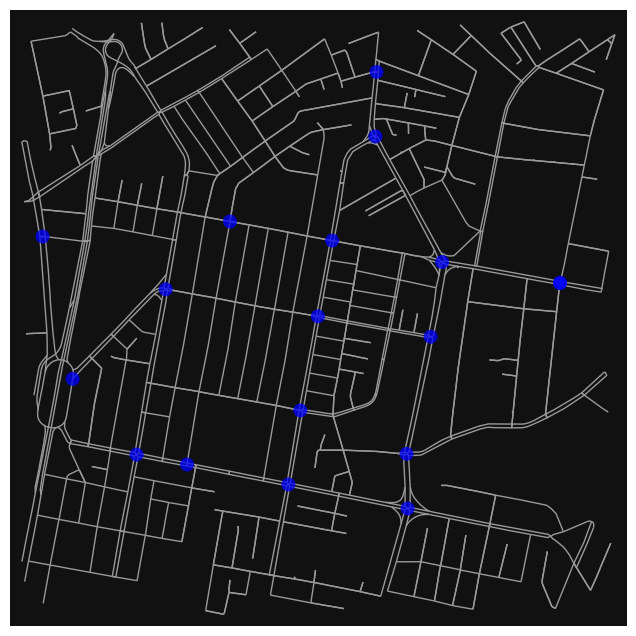

In [13]:
# Update matrix nodes values 

n = list(matriz.keys())

for i  in range (0 ,  len(n)): 
    matriz[n[i]] = nodes_ID[i]

matriz 

# plotting the traffic lights  in the city 
routes_g = []
for n in nodes_ID:
    route_G = nx.shortest_path(G, n, n)
    routes_g.append(route_G)

fig, ax = ox.plot_graph_routes(G, routes_g, route_colors='blue' , route_linewidth=6, node_size=0)

In [ ]:

# getting distance of the final path  the agent discovered 
distance = functions.get_length(initial_node , final_node , real_path , G )

distance


[0.065901,
 0.047913,
 0.10133567611128844,
 0.07501207563016521,
 0.14579999999999999,
 0.10013558909919591,
 0.11475837143218769,
 0.08158412685275528,
 0.11994200000000001,
 0.043853076128342244,
 0.17779758770454135,
 0.10585812810237898,
 0.08854278393750181,
 0.15062073656364453,
 0.048713741546956076,
 0.049949,
 0.09365000000000001,
 0.401746,
 0.092257,
 0.060794,
 0.07962699999999999]

In [ ]:
# gettign the time it takes for the agent to travel acrros the path. No traffic lights add 
tiempo_de_recorrido , velocity = functions.tiempo_recorrido (distance )

tiempo_de_recorrido , velocity 

([0.0043934,
  0.002521736842105263,
  0.005960922124193437,
  0.004167337535009179,
  0.00972,
  0.0071525420785139935,
  0.00717239821451173,
  0.004799066285456193,
  0.006312736842105263,
  0.002579592713431897,
  0.011112349231533834,
  0.007561294864455641,
  0.0063244845669644155,
  0.007927407187560237,
  0.002865514208644475,
  0.0029381764705882353,
  0.005508823529411766,
  0.022319222222222223,
  0.0057660625,
  0.003799625,
  0.005308466666666666],
 [15,
  19,
  17,
  18,
  15,
  14,
  16,
  17,
  19,
  17,
  16,
  14,
  14,
  19,
  17,
  17,
  17,
  18,
  16,
  16,
  15])

In [ ]:
def probability_p( time ): 
    """
    functions that computes de probabiliy of stoping into a red light
    """

    time = time*(360)  # convertir a segundos
    
    dt_r = np.random.randint( 45 , 60 ) # seconds
    dt_v = np.random.randint(45 , 60 )  # seconds 

    # calculando p 
    p = dt_r/ (dt_r + dt_v)

    # guillespie 
    P = np.exp(-(p*time))

    return P 

In [ ]:
semaforos_a = functions.get_trafficlights(matriz , real_path)

semaforos_a

[364, 44]

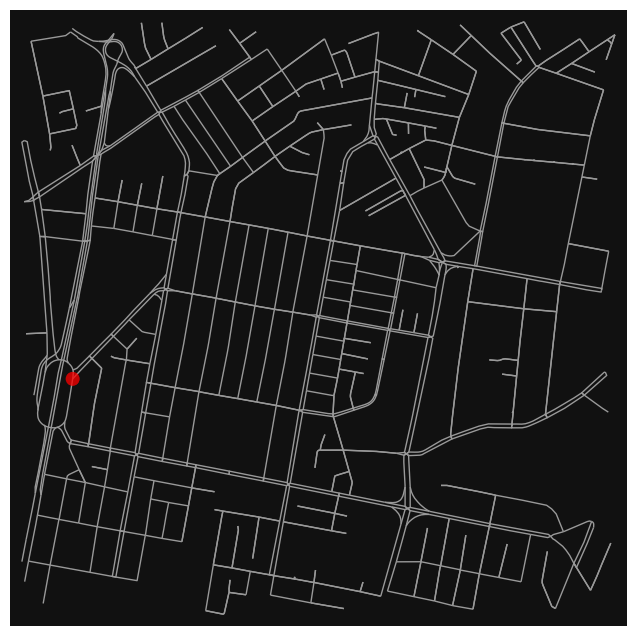

In [ ]:
functions.plot_node(364,364 , G)

In [ ]:
matriz = functions.matriz_de_semaforos()

matriz

{'Av. 6 de diembre y Pio valdiviedo': 230,
 'Av. 6 de Diciembre y los Shyris': 242,
 'Av. 6 de diciembre y Rio coca': 250,
 'Av. 6 de Diciembre y Tomas de berlanga': 272,
 'Av. 6 de diciembre y De los Granados': 2,
 'Av. 6 de diciembre y Gaspar de villaroel': 376,
 'Av. Shyris y Rio coca': 241,
 'Av. Shyris y Tomas berlanga': 273,
 'Av. Shyris e Isla floreana': 152,
 'Av. Shyris y Gaspar de villaroel': 150,
 'Av. Gaspara de villarroel e Isla San cristobal': 75,
 'Av. Amazonas y Gaspar de villarroel': 50,
 'Av. Amazonasa y Tomas de berlanga': 44,
 'Av. Rio coca e Isla san Cristobal': 58,
 'Av. Rio coca e Isla Marchena': 339,
 'Av. Rio coca y Eloy Alfaro': 339,
 'Av. 10 de agosto y Falconi': 33,
 'Av. 10 de Agosto y Juan de Ascaray': 364}

In [ ]:
probas = []
for time in tiempo_de_recorrido:
    p = probability_p(time)
    probas.append(p)

probas

[0.450073875075538,
 0.6445065532952069,
 0.36427349399856485,
 0.46265840577112227,
 0.17991079799015502,
 0.29975889448887444,
 0.2958347037890585,
 0.43345539408431216,
 0.28225918532236444,
 0.6259806780107309,
 0.14094268128712725,
 0.2639290597385287,
 0.3490675942056416,
 0.2719193396488667,
 0.623498988082175,
 0.572808295729686,
 0.34869331384639796,
 0.014631982454534433,
 0.31634277860221466,
 0.4980349378580183,
 0.3984655545628422]

In [ ]:
real_path

{53: 124,
 124: 123,
 123: 125,
 125: 141,
 141: 364,
 364: 142,
 142: 86,
 86: 346,
 346: 347,
 347: 44,
 44: 40,
 40: 39,
 39: 43,
 43: 42,
 42: 81,
 81: 80,
 80: 76,
 76: 79,
 79: 235,
 235: 244}

In [ ]:
path.insert(-1, final_node)

In [ ]:
path.pop(-1)

-1

In [ ]:
path

[52,
 53,
 124,
 123,
 125,
 141,
 364,
 142,
 86,
 346,
 347,
 44,
 40,
 39,
 43,
 42,
 81,
 80,
 76,
 79,
 235,
 244]

In [ ]:
real_path

{53: 124,
 124: 123,
 123: 125,
 125: 141,
 141: 364,
 364: 142,
 142: 86,
 86: 346,
 346: 347,
 347: 44,
 44: 40,
 40: 39,
 39: 43,
 43: 42,
 42: 81,
 81: 80,
 80: 76,
 76: 79,
 79: 235,
 235: 244}

In [ ]:
len(path)

22